In [25]:
import numpy as np
import matplotlib.pyplot as plt

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [26]:
# THIS IS USING CUBIC SPIRAL FOR TURNING
# Using quintic spiral for turning results in almost the same turning trajectory
v = 1
dt = 0.1
num_st_pts = int(v/dt)
num_pts = 50

def cubic_spiral(theta_i, theta_f, n=50):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    # return (theta_f-theta_i)*(6*x**5 - 15*x**4 + 10*x**3) + theta_i   # Use this for quintic plot if needed
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i
    
def straight(dist, curr_pose, n=num_st_pts):
    # dist is the straight distance to be travelled
    # the straight-line may be along x or y axis
    # curr_theta will determine the orientation
    # print(n)
    x0, y0, t0 = curr_pose
    xf, yf = x0 + dist*np.cos(t0), y0 + dist*np.sin(t0)
    x = (xf - x0) * np.linspace(0, 1, n) + x0
    y = (yf - y0) * np.linspace(0, 1, n) + y0
    return x, y, t0*np.ones_like(x)

def turn(change, curr_pose, n=num_pts):
     # adjust scaling constant for desired turn radius
     # change is the angle by which we want to turn, like 90 or -90
    #  print(n)
     x0, y0, t0 = curr_pose
     theta = cubic_spiral(t0, t0 + np.deg2rad(change), n)
     # cumsum() is basically integration
     x= x0 + np.cumsum(v*np.cos(theta)*dt)
     y= y0 + np.cumsum(v*np.sin(theta)*dt)
     return x, y, theta

def generate_trajectory(route, init_pose = (0, 0,np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]  # Pull last element of px, py, pt to get latest orientation
        # print(np.round(px[-1],2),np.round(py[-1],2),np.round(pt[-1],2))   # This is the final position after every route iteration
        # Add latest pose to array
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt]) 
    # print(x[-1], y[-1], t[-1])   # This is the final position
    return x, y, t

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

<Figure size 432x288 with 0 Axes>

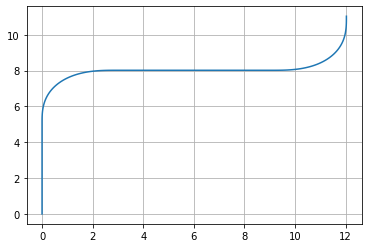

<Figure size 432x288 with 0 Axes>

In [27]:
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
x, y, _ = generate_trajectory(route)
plt.plot(x, y)
plt.grid()
plt.figure()

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

slope value:  1


<Figure size 432x288 with 0 Axes>

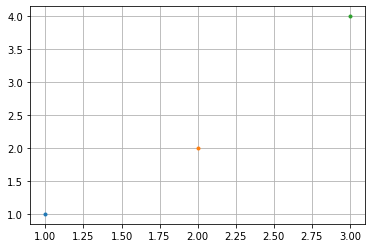

<Figure size 432x288 with 0 Axes>

In [28]:
#To find the corner point:
x1, y1 = 1, 1
x2, y2 = 2, 2   # Test values
x3, y3 = 3, 4

slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)   # equation given above
print("slope value: ", slope)

plt.plot(x1, y1, '.') # Blue
plt.plot(x2, y2, '.') # Orange
plt.plot(x3, y3, '.') # Green
plt.grid()
plt.figure()

# If slope value is < 0, then you have to bend towards RIGHT while going from x1, y1 to x3, y3
# If slope value is = 0, then  x1, y1 to x3, y3 is a straight line
# If slope value is > 0, then you have to bend towards LEFT while going from x1, y1 to x3, y3


<Figure size 432x288 with 0 Axes>

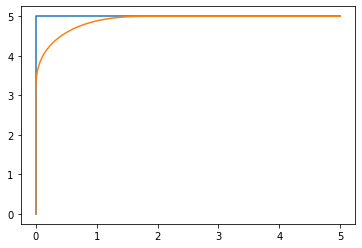

<Figure size 432x288 with 0 Axes>

In [29]:
def rough_trajectory(route, init_pose):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]  # Pull last element of px, py, pt to get latest orientation
        # print(np.round(px[-1],2),np.round(py[-1],2),np.round(pt[-1],2)) 
        # Add latest pose to array
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt]) 
    return x[-1], y[-1], t[-1]

# here is a code to generate 2 orthogonal 
# line segments of lengths 6

s1, s2 = 6, 6
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
# passing -1 as index gives last element of array, similarly -2 gives 2nd last etc
y2 = [y1[-1]]*s2

# [:-1] slices the list to omit the last element similarly [:-2] omits last 2 elements
x, y = x1[:-1]+x2, y1[:-1]+y2
# print(x,y)
plt.figure()
plt.plot(x, y)
plt.grid()

#find the corner point and plot it
corners = []
for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
  slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
  if slope > 0.0:   # Turn left, change in theta is pi/2
    corners.append([x2, y2, 90])
  if slope < 0.0:   # Turn right, change in theta is -pi/2
    corners.append([x2, y2, -90])

# print(corners)

# Fix a turn radius r 
r = 2
dt = 0.1
v = (1/3.0152)*r  

# convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
curr_pose = [0, 0, np.pi/2]
route = []
xc, yc, tc = curr_pose
for xp, yp, tp in corners:
  # Shorten the straight segments by r
  straight_distance = np.sqrt((xc-xp)**2  + (yc-yp)**2) - r
  route.append(("straight", straight_distance))   # Add straight line distance
  route.append(("turn", tp))   # Add turn angle
  latest_pose = [xc, yc, tc]
  xc, yc, tc = rough_trajectory(route, curr_pose)
# print(xc, yc, tc)
route.append(("straight", 3))

# use generate_trajectory() and plot the smooth path
xe, ye, _ = generate_trajectory(route)
plt.plot(xe, ye)
plt.grid()
plt.figure()

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

In [30]:
path = [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2),
        (3, 2), (4, 2), (5, 2), (6, 2), (6, 3),
        (6, 4), (6, 5), (7, 5), (8, 5), (9, 5), 
        (10, 5), (11, 5), (12, 5), (13, 5), (14, 5),
        (14, 4), (14, 3), (14, 2), (14, 1), (15, 1),
        (16, 1), (17, 1), (18, 1), (18, 2), (18, 3),
        (17, 3), (17, 4), (17, 5), (17, 6), (17, 7),
        (17, 8), (17, 9), (17, 10), (17, 11), (17, 12),
        (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), 
        (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), 
        (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), 
        (10, 13), (10, 14), (9, 14), (9, 15), (9, 16),
        (8, 16), (7, 16), (7, 17), (7, 18), (6, 18),
        (5, 18), (4, 18), (3, 18), (2, 18), (1, 18),
        (0, 18),(0, 19)]

# print(path)
path_x = []
path_y = [] 
for i,j in path:
  path_x.append(i)
  path_y.append(j)
# print(path_x, path_y)

In [31]:
#find the corner point and plot it
corners = []
for x1,x2,x3, y1,y2,y3 in zip(path_x[:-2],path_x[1:-1],path_x[2:],path_y[:-2],path_y[1:-1],path_y[2:]):
  slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
  if slope > 0.0:   # Turn left, change in theta is pi/2
    corners.append([x2, y2, 90])
  if slope < 0.0:   # Turn right, change in theta is -pi/2
    corners.append([x2, y2, -90])
print(corners)


[[0, 2, -90], [6, 2, 90], [6, 5, -90], [14, 5, -90], [14, 1, 90], [18, 1, 90], [18, 3, 90], [17, 3, -90], [17, 14, 90], [13, 14, 90], [13, 10, -90], [10, 10, -90], [10, 14, 90], [9, 14, -90], [9, 16, 90], [7, 16, -90], [7, 18, 90], [0, 18, -90]]


In [32]:
# For error correction and getting latest pose
def rough_trajectory(route, init_pose):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command, curr_pose)
        curr_pose = px[-1],py[-1],pt[-1]  # Pull last element of px, py, pt to get latest orientation
        # print(np.round(px[-1],2),np.round(py[-1],2),np.round(pt[-1],2)) 
        # Add latest pose to array
        x = np.concatenate([x, px])
        y = np.concatenate([y, py])
        t = np.concatenate([t, pt]) 
    return x[-1], y[-1], t[-1]

In [33]:
# Fix a turn radius r 
r = 0.5   # A sharp turn needs to be defined as there is not enough space for a 1 metre turn
dt = 0.1
v = (1/3.0152)*r  

curr_pose = [0, 0, np.pi/2]
route = []
xc, yc, tc = curr_pose
i = 1
for xp, yp, tp in corners:
  # print(f"Iteration {i}")
  # print(f"xc: {xc}  yc: {yc}  tc: {tc}")
  # print(f"Turning pointing: xp: {xp}  yp: {yp}  tp: {tp}")
  straight_distance = np.sqrt((xc-xp)**2  + (yc-yp)**2) - r
  if straight_distance < 0: straight_distance = 0 
  # print(f"straight_distance: {straight_distance}")
  route.append(("straight", straight_distance))   # Add straight line distance
  route.append(("turn", tp))   # Add turn angle
  latest_pose = [xc, yc, tc]
  xc, yc, tc = rough_trajectory(route, curr_pose)
  # print("Current position: ",xc, yc, tc)
  # i = i+1
  # print("\n")

# route.append(("straight", 4))

# Display the route:
# for manoeuvre, command in route:
#   print("\n",manoeuvre, command)

<Figure size 432x288 with 0 Axes>

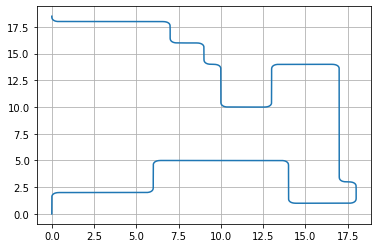

<Figure size 432x288 with 0 Axes>

In [34]:
# use generate_trajectory() and plot the smooth path
x1, y1, _ = generate_trajectory(route)
plt.plot(x1, y1)
plt.grid()
plt.figure()

The next plot  also plots the corners for better visualization of the smooth path generated and followed.

<Figure size 432x288 with 0 Axes>

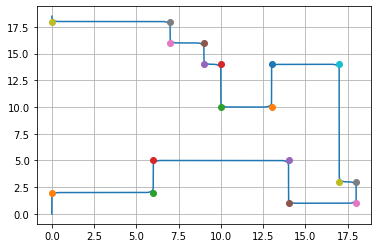

<Figure size 432x288 with 0 Axes>

In [35]:
# use generate_trajectory() and plot the smooth path
x1, y1, _ = generate_trajectory(route)
plt.plot(x1, y1)
for i,j, _ in corners:  # Plot corners for better visualization
  plt.plot(i,j,'o')
plt.grid()
plt.figure()

This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs